<blockquote>
    <h1>Exercise 8.10</h1>
    <p>We now use boosting to predict $\mathrm{Salary}$ in the <code>Hitters</code> data set.</p>
    <ol>
        <li>Remove the observations for whom the salary information is unknown, and then log-transform the salaries.</li>
        <li>Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.</li>
        <li>Perform boosting on the training set with $1000$ trees for a range of values of the shrinkage parameter $\lambda$. Produce a plot with different shrinkage values on the $x$-axis and the corresponding training set MSE on the $y$-axis.</li>
        <li>Produce a plot with different shrinkage values on the $x$-axis and the corresponding test set MSE on the $y$-axis.</li>
        <li>Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.</li>
        <li>Which variables appear to be the most important predictors in the boosted model?</li>
        <li>Now apply bagging to the training set. What is the test set MSE for this approach?</li>
    </ol>
</blockquote>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder  # https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv("../../DataSets/Hitters/Hitters.csv", index_col = 0)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
# Convert categorical independent data using one hot encoding:
# which takes a column with categorical data and 
# then splits the column into multiple columns. 
# The numbers are replaced by 1s and 0s, depending 
# on which column has what value. 
categorical_lst = ['League', 'Division', 'NewLeague']
columns = df.columns.tolist()
indices = [index for index, column in enumerate(columns) if column in categorical_lst]

onehotencoder = OneHotEncoder()
categorical_transformed = onehotencoder.fit_transform(df[categorical_lst]).toarray()
    
new_categorical_lst = []
for categorical_name, np_arr in zip(categorical_lst, onehotencoder.categories_):
    temp_lst = [f'{categorical_name} ({category})' for category in np_arr]
    new_categorical_lst.extend(temp_lst)
    
df_categorical_transformed = pd.DataFrame(categorical_transformed, 
                                          columns=new_categorical_lst, 
                                          index=df.index,
                                          dtype='int64')
for column in new_categorical_lst:
    df_categorical_transformed[column] = df_categorical_transformed[column].astype('category')

df_transformed = pd.concat([df.drop(categorical_lst, 1), df_categorical_transformed], axis=1)
df_transformed.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League (A),League (N),Division (E),Division (W),NewLeague (A),NewLeague (N)
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,...,446,33,20,NaN,1,0,1,0,1,0
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1


<h3>Exercise 8.10.1</h3>
<blockquote>
    <i>Remove the observations for whom the salary information is unknown, and then log-transform the salaries.</i>
</blockquote>

In [4]:
df.dropna(inplace=True)
df['Salary_log'] = np.log(df['Salary'])

df_transformed.dropna(inplace=True)
df_transformed['Salary_log'] = df['Salary_log'].copy()

<h3>Exercise 8.10.2</h3>
<blockquote>
    <i>Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.</i>
</blockquote>

In [5]:
df_y = df_transformed[['Salary_log']]
df_x = df_transformed.drop(['Salary', 'Salary_log'], 1)
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_x, 
    df_y, 
    train_size=200, 
    random_state=42
)

<h3>Exercise 8.10.3</h3>
<blockquote>
    <i>Perform boosting on the training set with $1000$ trees for a range of values of the shrinkage parameter $\lambda$. Produce a plot with different shrinkage values on the $x$-axis and the corresponding training set MSE on the $y$-axis.</i>
</blockquote>

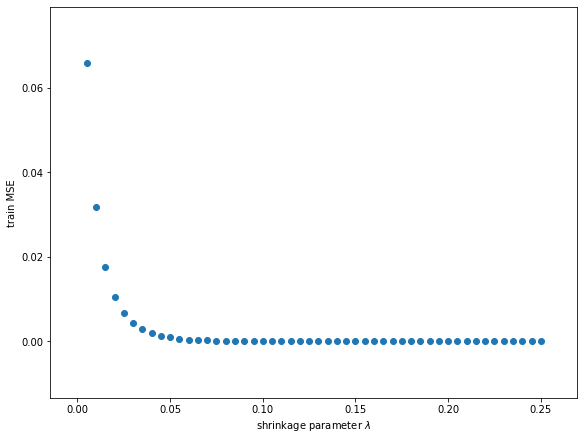

In [6]:
B = 1000
d = 3 # number of splits in each tree

lambda_arr = np.linspace(0.005, 0.25, 50)
MSE_train_arr = np.empty(shape=(lambda_arr.shape[0], ))
MSE_test_arr = np.empty(shape=(lambda_arr.shape[0], ))
for index, lambda_ in enumerate(lambda_arr):
    boosting_reg = GradientBoostingRegressor(
        learning_rate=lambda_,
        n_estimators=B,
        max_leaf_nodes=d+1,
        max_depth=None,
        random_state=42
    )
    _ = boosting_reg.fit(df_x_train, df_y_train['Salary_log'])
    
    y_pred_train = boosting_reg.predict(df_x_train)
    MSE_train_arr[index] = mean_squared_error(y_pred_train, df_y_train)
    
    y_pred_test = boosting_reg.predict(df_x_test)
    MSE_test_arr[index] = mean_squared_error(y_pred_test, df_y_test)
    
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))
_ = ax.scatter(lambda_arr, MSE_train_arr)
_ = ax.set_xlabel(r'shrinkage parameter $\lambda$')
_ = ax.set_ylabel(r'train MSE')

<h3>Exercise 8.10.4</h3>
<blockquote>
    <i>Produce a plot with different shrinkage values on the $x$-axis and the corresponding test set MSE on the $y$-axis.</i>
</blockquote>

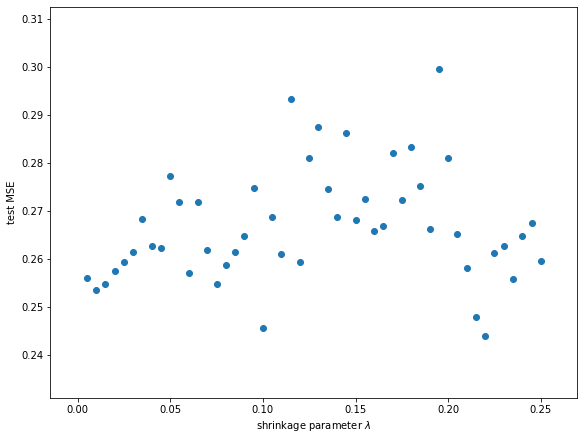

In [7]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))
_ = ax.scatter(lambda_arr, MSE_test_arr)
_ = ax.set_xlabel(r'shrinkage parameter $\lambda$')
_ = ax.set_ylabel(r'test MSE')

<p>This doesn't look very reliable, so we will use cross-validation to evaluate the shrinkage parameter.</p>

In [8]:
boosting_reg = GradientBoostingRegressor(
    n_estimators=B,
    max_leaf_nodes=d+1,
    max_depth=None,
    random_state=42
)
grid_search = GridSearchCV(boosting_reg, {'learning_rate': np.linspace(0, 0.1, 251)[1:]},
                           n_jobs=-1, scoring='neg_mean_squared_error')
_ = grid_search.fit(df_x, df_y['Salary_log'])

print(grid_search.best_estimator_)
print(grid_search.best_score_)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.007200000000000001,
                          loss='ls', max_depth=None, max_features=None,
                          max_leaf_nodes=4, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=1000, n_iter_no_change=None,
                          presort='deprecated', random_state=42, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)
-0.19222308571540925


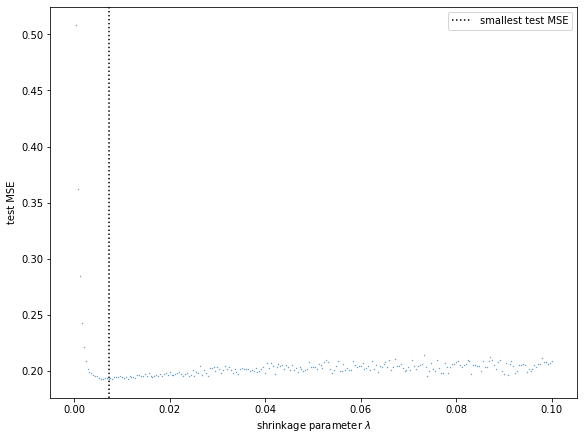

In [9]:
lambda_arr = [params_dct['learning_rate'] for params_dct in grid_search.cv_results_['params']]
MSE_test_arr = - grid_search.cv_results_['mean_test_score']

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))
_ = ax.scatter(lambda_arr, MSE_test_arr, s=0.1)
_ = ax.set_xlabel(r'shrinkage parameter $\lambda$')
_ = ax.set_ylabel(r'test MSE')
id_min = np.argmin(MSE_test_arr)
_ = ax.axvline(lambda_arr[id_min], color='black', linestyle=':', label='smallest test MSE')
_ = ax.legend()

<h3>Exercise 8.10.5</h3>
<blockquote>
    <i>Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.</i>
</blockquote>

<p>We first perform a multiple linear regression on the training data.</p>

In [10]:
lin_reg = LinearRegression()
_ = lin_reg.fit(df_x_train, df_y_train)
Y_pred_test = lin_reg.predict(df_x_test)
mean_squared_error(Y_pred_test, df_y_test)

0.4472727400525929

<p>Let us now investigate the ridge regression.</p>

In [11]:
grid_search = GridSearchCV(Ridge(), {'alpha': np.linspace(0, 100, 251)[1:]},
                           n_jobs=-1, scoring='neg_mean_squared_error')
_ = grid_search.fit(df_x, df_y)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

Ridge(alpha=95.60000000000001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
-0.4350218484276212


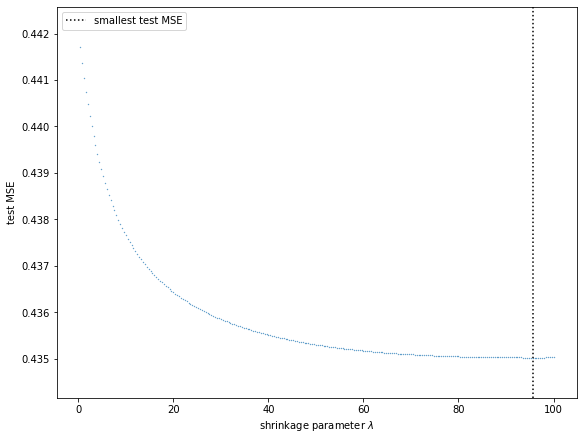

In [12]:
lambda_arr = [params_dct['alpha'] for params_dct in grid_search.cv_results_['params']]
MSE_test_arr = - grid_search.cv_results_['mean_test_score']

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))
_ = ax.scatter(lambda_arr, MSE_test_arr, s=0.1)
_ = ax.set_xlabel(r'shrinkage parameter $\lambda$')
_ = ax.set_ylabel(r'test MSE')
id_min = np.argmin(MSE_test_arr)
_ = ax.axvline(lambda_arr[id_min], color='black', linestyle=':', label='smallest test MSE')
_ = ax.legend()

<p>Finally, we fit the lasso regression on the data set.</p>

In [13]:
grid_search = GridSearchCV(Lasso(max_iter=10000), {'alpha': np.linspace(0, 0.02, 251)[1:]},
                           n_jobs=-1, scoring='neg_mean_squared_error')
_ = grid_search.fit(df_x, df_y)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

Lasso(alpha=0.00824, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
-0.4369229319142229


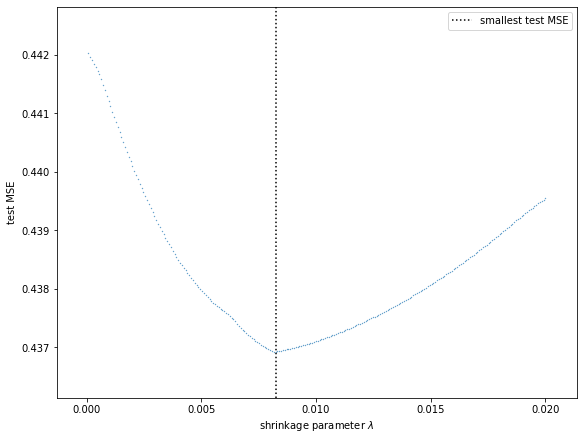

In [14]:
lambda_arr = [params_dct['alpha'] for params_dct in grid_search.cv_results_['params']]
MSE_test_arr = - grid_search.cv_results_['mean_test_score']

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))
_ = ax.scatter(lambda_arr, MSE_test_arr, s=0.1)
_ = ax.set_xlabel(r'shrinkage parameter $\lambda$')
_ = ax.set_ylabel(r'test MSE')
id_min = np.argmin(MSE_test_arr)
_ = ax.axvline(lambda_arr[id_min], color='black', linestyle=':', label='smallest test MSE')
_ = ax.legend()

<h3>Exercise 8.10.6</h3>
<blockquote>
    <i>Which variables appear to be the most important predictors in the boosted model?</i>
</blockquote>

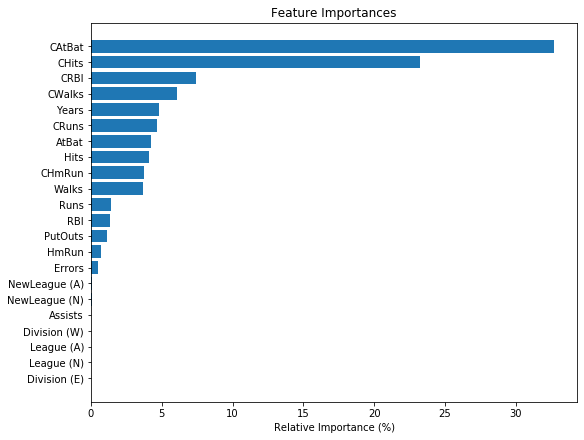

In [15]:
optimum_learning_rate = 0.0072
boosting_reg = GradientBoostingRegressor(
    learning_rate=optimum_learning_rate,
    n_estimators=B,
    max_leaf_nodes=d+1,
    max_depth=None,
    random_state=42
)
_ = boosting_reg.fit(df_x, df_y['Salary_log'])

importances = 100 * boosting_reg.feature_importances_
indices = np.argsort(importances)
columns = df_x.columns.tolist()

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))

_ = ax.barh(range(len(indices)), importances[indices], align='center')
_ = ax.set_yticklabels([columns[i] for i in indices])
_ = ax.set_yticks(range(len(indices)))
_ = ax.set_xlabel('Relative Importance (%)')
_ = ax.set_title('Feature Importances')

<h3>Exercise 8.10.7</h3>
<blockquote>
    <i>Now apply bagging to the training set. What is the test set MSE for this approach?</i>
</blockquote>

In [16]:
number_of_trees = 500
sample_size = df_x_train.shape[0]
bag = BaggingRegressor(
    DecisionTreeRegressor(
        criterion='mse', 
        splitter='best', 
        max_leaf_nodes=d+1,
        max_depth=None,
        random_state=42
    ),
    oob_score=True,
    n_estimators=B,
    max_samples=sample_size,
    bootstrap=True,
    n_jobs=-1
)

_ = bag.fit(df_x_train, df_y_train.squeeze())
Y_oob_pred = bag.oob_prediction_
MSE_oob = mean_squared_error(Y_oob_pred, df_y_train)
print(f'out-of-bag MSE = {MSE_oob:.2f}')

y_pred = bag.predict(df_x_test)
MSE = mean_squared_error(y_pred, df_y_test)
print(f'test MSE = {MSE:.2f}')

out-of-bag MSE = 0.22
test MSE = 0.36


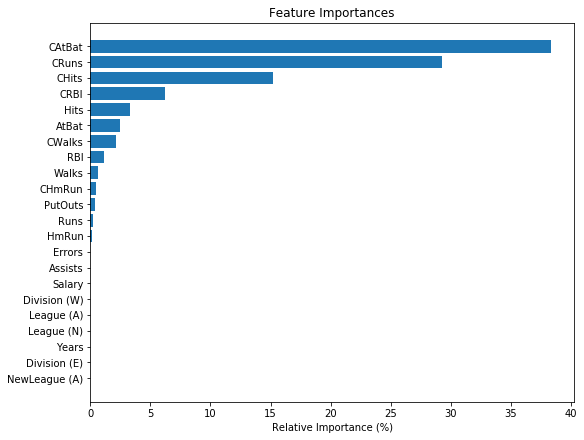

In [17]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)


importances = 100 * feature_importances
indices = np.argsort(importances)
columns = df_transformed.columns.tolist()

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))

_ = ax.barh(range(len(indices)), importances[indices], align='center')
_ = ax.set_yticklabels([columns[i] for i in indices])
_ = ax.set_yticks(range(len(indices)))
_ = ax.set_xlabel('Relative Importance (%)')
_ = ax.set_title('Feature Importances')